# **Introduction**

The goal of this Jupyter notebook is to build an LLM-based assistant that specializes in answering questions related to "how to use the Oura app." To accomplish this, we will implement a retrieval-augmented generation (RAG) pipeline using `gpt-4o-mini` as our base model. 

We will follow these steps:

1) **Data Collection**: Scrape text information related to Oura from multiple sources about Oura.
2) **Vector Database Collection**: Process the scraped text by chunking it into manageable segments, convert these chunks into vector embeddings using OpenAI's embedding model, and store them in Pinecone (our vector database of choice).
3) **Query Classification**: Develop an "In-Scope Model" to determine whether a user question is related to the Oura app or outside our domain of expertise.
4) **RAG Pipeline Implementation**: Build a system that first classifies incoming questions, then for in-scope queries, enhances `gpt-4o-mini` with relevant context retrieved from our Pinecone database to generate accurate, sourced answers.
5) **Performance Evaluation**: Assess the effectiveness of both the In-Scope Model and the overall RAG pipeline using appropriate metrics.
6) **User Interface**: Deploy the complete system on Gradio for interactive testing and demonstration.
   
### Assumption that Will Be Made

1) Content from YouTube and Reddit is considered reliable and factually accurate regarding Oura usage.
2) `gpt-4o-mini` possesses sufficient baseline knowledge about Oura, allowing us to focus on enhancing its capabilities rather than addressing fundamental knowledge gaps.
3) Our chosen parameters (2500-character chunks with 500-character overlap) represent an optimal chunking strategy without extensive parameter tuning.
4) OpenAI's `text-embedding-3-small` embedding model provides the best performance for our use case without comparative testing.
5) The prompts implemented in this pipeline represent optimal formulations without extensive A/B testing.
6) Retrieving the top 3 most similar documents (k=3) from our vector store provides sufficient context without introducing noise.
7) Our manually created expected answers for evaluation questions accurately represent ideal responses.
8) Our evaluation set (15 questions total: 5 out-of-scope, 5 Oura app usage, 5 general Oura ring questions) sufficiently represents real-world user query patterns.

# **Importing Relevant Libraries**

In [1]:
# Standard libraries
import os
import re
import sys
import time
import glob
from typing import List, Optional
from urllib.parse import urljoin, urlparse
import requests

# Data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt

# Web scraping and API
import requests
from bs4 import BeautifulSoup
import praw
from tqdm import tqdm
from dotenv import load_dotenv

# LangChain
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_core.documents import Document
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema, PydanticOutputParser

# Pinecone
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

# Pydantic
from pydantic import BaseModel, Field

# Gradio
import gradio as gr

# LangSmith
from langsmith import Client, traceable
from langsmith.evaluation import LangChainStringEvaluator


# **Importing API Keys**

In [2]:
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
SCRAPINGBEE_API_KEY = os.environ.get("SCRAPINGBEE_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")

# **Building the Vector Knowledge Base**

To build our knowledge database for the RAG Pipeline, we will scrape text from various sources such as official websites from Oura, Reddit and Youtube videos. 

### Scraping Oura Websites

To scrape the Oura main website and it's support website, we will use the API from [ScrapingBee](https://www.scrapingbee.com). While BeautifulSoup or direct GET requests could be used, ScrapingBee provides a more reliable approach that avoids IP blocking and rate limiting issues that can occur with direct scraping.

Specifically, we will scrape:

1) https://support.ouraring.com/hc/en-us (official support documentation)
2) https://ouraring.com/ (main product website)
3) All relevant internal links from both domains that contain information about app usage

### Scraping Reddit

We'll extract user experiences and solutions from two key Reddit threads about Oura, capturing both top-level comments and their nested replies to preserve discussion context:

1) [Oura Support, Shipping, Delays, etc. Megathread](https://www.reddit.com/r/ouraring/comments/s4nbcw/oura_support_shipping_delays_etc_megathread)
2) [How do you use your Oura Ring?](https://www.reddit.com/r/ouraring/comments/15c7htw/how_do_you_use_your_oura_ring)

For Reddit scraping, we'll use a traditional GET request with a custom User-Agent header, as ScrapingBee has shown inconsistent results with Reddit's structure.

### Scraping Youtube Videos for their Transcripts

To capture instructional content, we've manually extracted transcripts from popular Oura tutorial videos using the [Kome AI YouTube transcript generator](https://kome.ai/tools/youtube-transcript-generator):

1) [Oura Ring 4 - Ultimate Beginner's Guide 2025](https://www.youtube.com/watch?v=j9q843YtRqg&ab_channel=ShervinShares)
2) [OURA Ring - First 30 Things To Do! (Tips & Tricks)](https://www.youtube.com/watch?v=DRCRmR611Sk&t=379s&ab_channel=HotshotTek)

These transcripts have already been processed and stored in the 'scraped_text' folder, so no additional code for this extraction is included in this notebook.

### **Identifying and Harvesting Internal Links from Oura Websites**

In this step, we systematically identify and collect internal links from both the Oura main website and the Oura Support Website, storing the URLs in separate text files for subsequent content extraction.

Automatically discovering all relevant internal links from complex websites presents significant challenges. While our automated scraper captures many links, ensuring comprehensive coverage of critical app documentation required manual intervention. To guarantee our knowledge base includes all essential information about Oura app usage, I manually supplemented the automated collection with links from the dedicated app documentation section at https://support.ouraring.com/hc/en-us/categories/27782541623059-Oura-App.

This hybrid approach ensures our retrieval system has access to all official documentation related to app functionality, which is critical for answering user questions accurately.

After compiling these URLs, we proceed to extract the textual content from each link, resulting in two comprehensive text files containing the full content from the Oura main website and the Support Website respectively. These text documents will serve as the foundation for our knowledge base after chunking and embedding.

In [3]:
def scrape_page(url):
    """Scrapes a single webpage using ScrapingBee and returns its HTML."""
    response = requests.get(
        url="https://app.scrapingbee.com/api/v1/",
        params={
            "api_key": SCRAPINGBEE_API_KEY,
            "url": url,
            "render_js": "false"
        },
        timeout=30
    )
    if response.status_code == 200:
        return response.text  # Return raw HTML
    else:
        print(f"Failed to scrape {url}, status code: {response.status_code}")
        return None

def get_internal_links(base_url):
    """Extracts all internal links from the given website."""
    html = scrape_page(base_url)
    if not html:
        print(f"Failed to retrieve homepage HTML: {base_url}")
        return []

    soup = BeautifulSoup(html, "html.parser")
    links = set()

    for a_tag in soup.find_all("a", href=True):
        raw_link = a_tag["href"]
        full_url = urljoin(base_url, raw_link)  # Convert relative to absolute

        # Ensure it's an internal link
        if urlparse(full_url).netloc == urlparse(base_url).netloc:
            links.add(full_url)

    return sorted(links)  # Sort for easier reading

# Extract links from both main Oura website and support site
main_base_url = "https://ouraring.com/"
support_base_url = "https://support.ouraring.com/"

print("Extracting links from Oura main site...")
main_links = get_internal_links(main_base_url)
print(f"Found {len(main_links)} internal links.")

print("\nExtracting links from Oura support site...")
support_links = get_internal_links(support_base_url)
print(f"Found {len(support_links)} internal links.")

# Save extracted links to files
def save_links(filename, links):
    with open(filename, "w", encoding="utf-8") as f:
        for link in links:
            f.write(link + "\n")

save_links("ouraring_links.txt", main_links)
save_links("support_links.txt", support_links)

print("\nInternal link extraction complete. Links saved to files.")


Extracting links from Oura main site...
Found 38 internal links.

Extracting links from Oura support site...
Found 19 internal links.

Internal link extraction complete. Links saved to files.


In [4]:
# Load links from files
def load_links(filename):
    """Reads URLs from a file and returns them as a list."""
    try:
        with open(filename, "r", encoding="utf-8") as f:
            return [line.strip() for line in f.readlines()]
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []

main_links = load_links("ouraring_links.txt")
support_links = load_links("support_links.txt")

# Track failed scrapes
failed_urls = []

def scrape_page(url, max_retries=3, backoff_factor=2):
    """Scrapes a single webpage using ScrapingBee and returns its text content."""
    for attempt in range(max_retries):
        try:
            response = requests.get(
                url="https://app.scrapingbee.com/api/v1/",
                params={
                    "api_key": SCRAPINGBEE_API_KEY,
                    "url": url,
                    "render_js": "false"
                },
                timeout=30
            )
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                text = soup.get_text(separator=" ")
                return " ".join(text.split())  # Clean up whitespace
            else:
                print(f"Failed to scrape {url}, status code: {response.status_code}")
        except requests.Timeout:
            print(f"Attempt {attempt + 1}: Request to scrape {url} timed out.")
        except Exception as e:
            print(f"Attempt {attempt + 1}: Error scraping {url}: {str(e)}")
        
        # Exponential backoff before retrying
        time.sleep(backoff_factor ** attempt)
    print(f"Failed to scrape {url} after {max_retries} attempts.")
    failed_urls.append(url)
    return None

# Scrape content from all extracted pages
scraped_data_main = {}
scraped_data_support = {}

for url in main_links:
    print(f"Scraping main site: {url}")
    scraped_text = scrape_page(url)
    if scraped_text:
        scraped_data_main[url] = scraped_text

for url in support_links:
    print(f"Scraping support site: {url}")
    scraped_text = scrape_page(url)
    if scraped_text:
        scraped_data_support[url] = scraped_text

# Create scraped_text folder if it doesn't exist
os.makedirs("scraped_text", exist_ok=True)

# Save scraped data
def save_scraped_data(filename, data):
    filepath = os.path.join("scraped_text", filename)
    with open(filepath, "w", encoding="utf-8") as f:
        for url, text in data.items():
            f.write(f"URL: {url}\n{text}\n\n{'='*80}\n\n")

save_scraped_data("ouraring_scraped_texts.txt", scraped_data_main)
save_scraped_data("support_scraped_texts.txt", scraped_data_support)

# Save failed URLs
if failed_urls:
    with open(os.path.join("scraped_text", "failed_urls.txt"), "w", encoding="utf-8") as f:
        for url in failed_urls:
            f.write(url + "\n")

print("\nScraping complete.")
print(f"Successfully scraped {len(scraped_data_main)} pages from Oura main site.")
print(f"Successfully scraped {len(scraped_data_support)} pages from Oura support site.")
if failed_urls:
    print(f"Failed to scrape {len(failed_urls)} pages. Check scraped_text/failed_urls.txt for details.")
else:
    print("All pages scraped successfully.")
print("Files saved in the 'scraped_text' folder.")

Scraping main site: https://ouraring.com/
Scraping main site: https://ouraring.com/#main-content
Scraping main site: https://ouraring.com/about-us
Scraping main site: https://ouraring.com/accessibility
Scraping main site: https://ouraring.com/activity-and-movement
Scraping main site: https://ouraring.com/blog
Scraping main site: https://ouraring.com/blog/the-future-of-wellness/
Scraping main site: https://ouraring.com/business
Scraping main site: https://ouraring.com/careers
Scraping main site: https://ouraring.com/contact
Scraping main site: https://ouraring.com/developer
Scraping main site: https://ouraring.com/fcc-compliance-statements
Scraping main site: https://ouraring.com/heart-health
Scraping main site: https://ouraring.com/heart-rate-monitoring
Scraping main site: https://ouraring.com/how-it-works
Scraping main site: https://ouraring.com/integrations
Scraping main site: https://ouraring.com/intellectual-property-notice
Scraping main site: https://ouraring.com/leadership
Scrapi

### **Extracting Knowledge from Reddit Discussions**

To capture community-based knowledge and real user experiences, we'll scrape two key Reddit threads that contain valuable information about Oura ring usage:

1) [Oura Support, Shipping, Delays, etc. Megathread](https://www.reddit.com/r/ouraring/comments/s4nbcw/oura_support_shipping_delays_etc_megathread)
2) [How do you use your Oura Ring?](https://www.reddit.com/r/ouraring/comments/15c7htw/how_do_you_use_your_oura_ring)

Our extraction process will:

- Capture the original post content for context
- Retrieve top-level comments sorted by relevance
- Include nested replies to preserve conversation context and follow-up information

This user-generated content often contains practical usage tips, troubleshooting advice, and feature explanations that complement the official documentation. The extraction script will process each thread and output a structured text file preserving the hierarchical nature of Reddit discussions.

The resulting text files will serve as additional knowledge sources for our RAG system, helping it address real-world usage scenarios and common user questions that might not be fully covered in official documentation.

In [5]:
# List of Reddit thread URLs to scrape
reddit_threads = [
    "https://www.reddit.com/r/ouraring/comments/s4nbcw/oura_support_shipping_delays_etc_megathread/.json",
    "https://www.reddit.com/r/ouraring/comments/15c7htw/how_do_you_use_your_oura_ring/.json"
]

# Custom headers to mimic a browser (Reddit blocks bots without this)
headers = {"User-Agent": "Mozilla/5.0"}

# Function to extract comments and nested replies
def extract_comments(comment_list, depth=0):
    """Recursively extracts comments and replies."""
    comments = []
    indent = "    " * depth  # Indentation for replies

    for comment in comment_list:
        if "body" in comment["data"]:  # Skip deleted comments
            comment_text = comment["data"]["body"]
            comment_author = comment["data"]["author"]
            comment_upvotes = comment["data"]["ups"]
            comments.append(f"{indent}{comment_author} ({comment_upvotes} upvotes): {comment_text}")

            # Check if this comment has replies
            if "replies" in comment["data"] and comment["data"]["replies"]:
                nested_comments = comment["data"]["replies"]["data"]["children"]
                comments.extend(extract_comments(nested_comments, depth + 1))  # Recursively extract replies

    return comments

# Function to clean thread title for filename use
def clean_filename(title):
    """Sanitizes the Reddit thread title to be used as a filename."""
    title = title[:50]  # Truncate long titles
    return re.sub(r'[<>:"/\\|?*]', '', title).replace(" ", "_") + ".txt"

# Folder to save Reddit thread data
output_folder = "scraped_text"
os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

# Process each Reddit thread
for reddit_thread_url in reddit_threads:
    response = requests.get(reddit_thread_url, headers=headers)

    if response.status_code == 200:
        reddit_data = response.json()

        # Extract post details
        post = reddit_data[0]["data"]["children"][0]["data"]
        post_title = post["title"]
        post_body = post["selftext"]
        post_author = post["author"]
        post_url = post["url"]
        post_upvotes = post["ups"]

        # Extract all comments and replies
        top_comments = reddit_data[1]["data"]["children"]
        all_comments = extract_comments(top_comments)

        # Generate a clean filename
        filename = clean_filename(post_title)
        file_path = os.path.join(output_folder, filename)

        # Write to a separate file for each thread
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(f"Title: {post_title}\n")
            f.write(f"Author: {post_author}\n")
            f.write(f"Upvotes: {post_upvotes}\n")
            f.write(f"URL: {post_url}\n\n")
            f.write(f"Post Content:\n{post_body}\n")
            f.write("=" * 80 + "\n\n")
            f.write("Comments:\n\n")

            for comment in all_comments:
                f.write(comment + "\n\n" + "-" * 80 + "\n\n")

        print(f"Successfully saved Reddit thread to {file_path}")

    else:
        print(f"Failed to fetch Reddit thread {reddit_thread_url}, status code: {response.status_code}")

print("\nAll Reddit threads saved in the 'scraped_text' folder.")


Successfully saved Reddit thread to scraped_text/Oura_Support,_Shipping,_Delays,_etc._Megathread.txt
Successfully saved Reddit thread to scraped_text/How_do_you_use_your_Oura_Ring.txt

All Reddit threads saved in the 'scraped_text' folder.


### **Generating Embeddings and Building the Vector Database**

In this critical step, we transform our raw text data into a searchable knowledge base by:

1) **Processing the collected documents**: We'll take all scraped content from Oura websites, Reddit discussions, and YouTube transcripts and prepare them for embedding.
2) **Chunking text into optimal segments**: Each document will be divided into 2500-character chunks with 500-character overlaps.
3) **Generating vector embeddings**: Using OpenAI's `text-embedding-3-small model`, we'll convert each text chunk into its vector representation.
4) **Preserving source information**: Each embedding will retain metadata about its origin, including the specific URL or source it came from, enabling proper attribution in responses.
5) **Indexing in Pinecone**: The embeddings and their metadata will be uploaded to our Pinecone vector database, which provides efficient similarity search capabilities.

This vector database forms the foundation of our retrieval system. When a user asks a question, we'll convert it to an embedding using the same model, then query Pinecone to find the most semantically similar text chunks to provide as context to the LLM.

The source metadata is particularly important as it enables our system to cite information sources in responses, enhancing trustworthiness and allowing users to verify information at the original sources when needed.

In [6]:
import os
import glob
import sys
import re
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_core.documents import Document

# Ensure API keys are set
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize Pinecone client
pc = Pinecone(api_key=PINECONE_API_KEY)

# Set Pinecone index name
INDEX_NAME = "oura-app-assistant"

# Folder where scraped text files are stored
TEXT_FOLDER = "scraped_text"

# Mapping of filenames to their respective source URLs
SOURCE_URLS = {
    "First30ThingsToDo.txt": "https://www.youtube.com/watch?v=DRCRmR611Sk&t=379s&ab_channel=HotshotTek",
    "UltimateBeginnersGuide2025.txt": "https://www.youtube.com/watch?v=j9q843YtRqg&ab_channel=ShervinShares",
    "ouraring_scraped_texts.txt": "https://ouraring.com/",
    "support_scraped_texts.txt": "https://support.ouraring.com/hc/en-us",
    "How_do_you_use_your_Oura_Ring.txt": "https://www.reddit.com/r/ouraring/comments/15c7htw/how_do_you_use_your_oura_ring/",
    "Oura_Support,_Shipping,_Delays,_etc._Megathread.txt": "https://www.reddit.com/r/ouraring/comments/s4nbcw/oura_support_shipping_delays_etc_megathread/"
}

# List of files that should have URL extraction
URL_EXTRACTION_FILES = ["ouraring_scraped_texts.txt", "support_scraped_texts.txt"]

# Increase chunk size for better RAG context
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2500,
    chunk_overlap=500,
    separators=["\n\n", "\n", " ", ""]
)

# Function to extract URL and content from text sections
def extract_sections(file_path):
    sections = []
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()
        
    # Split by the separator line
    raw_sections = content.split("="*80)
    
    for section in raw_sections:
        section = section.strip()
        if not section:
            continue
            
        # Extract URL
        url_match = re.search(r"URL: (https?://[^\s]+)", section)
        if url_match:
            url = url_match.group(1)
            # Remove the URL line from the content
            section_content = section.replace(url_match.group(0), "").strip()
            sections.append((url, section_content))
    
    return sections

# Process each file individually
all_chunks = []
processed_files = set()  # Track processed files

for file_path in glob.glob(os.path.join(TEXT_FOLDER, "*.txt")):
    filename = os.path.basename(file_path)
    
    # Ensure every file has a corresponding source URL
    if filename not in SOURCE_URLS:
        print(f"ERROR: No source URL found for file: {filename}. Please update SOURCE_URLS.")
        sys.exit(1)  # Immediately stop execution if a source URL is missing
    
    # Get corresponding source URL from the mapping
    source_url = SOURCE_URLS[filename]
    
    # Check if this file should have URL extraction
    if filename in URL_EXTRACTION_FILES:
        # Extract sections with URLs
        sections = extract_sections(file_path)
        section_count = 0
        
        for url, section_content in sections:
            # Create document with metadata including source URL
            doc = Document(page_content=section_content, metadata={"source": url})
            
            # Split this individual document
            section_chunks = text_splitter.split_documents([doc])
            
            # Add to our collection
            all_chunks.extend(section_chunks)
            section_count += len(section_chunks)
        
        print(f"Processed {filename} with URL extraction: created {section_count} chunks from {len(sections)} sections")
    else:
        # Process file normally without URL extraction
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
            
        # Create document with metadata including source URL
        doc = Document(page_content=text, metadata={"source": source_url})
        
        # Split this individual document
        file_chunks = text_splitter.split_documents([doc])
        
        # Add to our collection
        all_chunks.extend(file_chunks)
        print(f"Processed {filename} (Source: {source_url}): created {len(file_chunks)} chunks")
    
    processed_files.add(filename)

# Verify all expected files were processed
expected_files = set(SOURCE_URLS.keys())
missing_files = expected_files - processed_files
if missing_files:
    print(f"\n ERROR: The following expected files were NOT found in {TEXT_FOLDER}:")
    for missing_file in missing_files:
        print(f"   - {missing_file}")
    sys.exit(1)  # Stop execution if expected files are missing

# Initialize OpenAI embeddings with `text-embedding-3-small`
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=OPENAI_API_KEY)

# Create Pinecone vector store and push embeddings
vectorstore = PineconeVectorStore.from_documents(
    documents=all_chunks,
    embedding=embeddings,
    index_name=INDEX_NAME
)

print(f"\nSuccessfully stored {len(all_chunks)} text chunks in Pinecone from {len(processed_files)} files.")

Processed First30ThingsToDo.txt (Source: https://www.youtube.com/watch?v=DRCRmR611Sk&t=379s&ab_channel=HotshotTek): created 14 chunks
Processed UltimateBeginnersGuide2025.txt (Source: https://www.youtube.com/watch?v=j9q843YtRqg&ab_channel=ShervinShares): created 14 chunks
Processed ouraring_scraped_texts.txt with URL extraction: created 135 chunks from 38 sections
Processed Oura_Support,_Shipping,_Delays,_etc._Megathread.txt (Source: https://www.reddit.com/r/ouraring/comments/s4nbcw/oura_support_shipping_delays_etc_megathread/): created 51 chunks
Processed How_do_you_use_your_Oura_Ring.txt (Source: https://www.reddit.com/r/ouraring/comments/15c7htw/how_do_you_use_your_oura_ring/): created 4 chunks
Processed support_scraped_texts.txt with URL extraction: created 250 chunks from 92 sections

Successfully stored 468 text chunks in Pinecone from 6 files.


# **Building the Query Classification System**

A critical component of our specialized assistant is the ability to distinguish between questions that are within our domain of expertise (about the Oura ring or app) and those that fall outside our scope. To accomplish this, we'll develop an "In-Scope Model" using `gpt-4o-mini` where it analyzes each incoming question and makes a binary classification:

- Returns `True` for Oura-related queries that should be processed through our RAG system
- Returns `False` for out-of-scope questions that should receive a standard response


In [8]:
# Define output schema for structured response
response_schemas = [
    ResponseSchema(name="is_oura_related", description="Is this question about Oura? (true/false)", type="boolean"),
    ResponseSchema(name="explanation", description="Brief explanation why this is or isn't related", type="string")
]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

# Create prompt template
scope_template = """
You are an expert on the Oura ring and Oura app.
Determine if the following question is related to using the Oura app or ring.
Provide the structured response.
Question: {question}
{format_instructions}
"""

scope_prompt = PromptTemplate(
    template=scope_template,
    input_variables=["question"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()}
)

# Initialize the LLM (OpenAI Chat Model)
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY)

def is_in_scope(question):
    """Checks if a question is related to Oura using LLM classification."""
    _input = scope_prompt.format(question=question)
    output = llm.invoke(_input)
    parsed_output = output_parser.parse(output.content)
    return parsed_output  # Returns structured response

# Test the classifier with sample questions
sample_questions = [
    "How does the Oura ring measure sleep?",
    "Can I use my Apple Watch with Oura?",
    "What is the best exercise for weight loss?",
    "Why is my Oura ring not syncing with the app?",
    "How do I reset my Fitbit?"
]

for question in sample_questions:
    result = is_in_scope(question)
    print(f"Question: {question}")
    print(f"Is Oura Related: {result['is_oura_related']}")
    print(f"Explanation: {result['explanation']}")
    print("-" * 80)

Question: How does the Oura ring measure sleep?
Is Oura Related: True
Explanation: The question is related to the Oura ring as it specifically asks about how the ring measures sleep, which is a core function of the device.
--------------------------------------------------------------------------------
Question: Can I use my Apple Watch with Oura?
Is Oura Related: True
Explanation: The question is related to Oura because it inquires about the compatibility of the Oura ring with another device, the Apple Watch, which is relevant to the use of the Oura app and ring.
--------------------------------------------------------------------------------
Question: What is the best exercise for weight loss?
Is Oura Related: False
Explanation: The question about the best exercise for weight loss is not specifically related to the Oura app or ring, as it does not pertain to their features, functionalities, or data tracking.
----------------------------------------------------------------------------

# **Implementation and Evaluation of the RAG pipeline**

This section implements the complete RAG system and tests its effectiveness on a diverse set of queries. The system combines several components working together:

### **Architecture Overview**

1) **Question Classification**: Every query first passes through our In-Scope Model to determine if it's about Oura. This prevents the system from attempting to answer questions outside its domain expertise.
2) **Contextual Retrieval**: For in-scope questions, we generate an embedding of the query and use Pinecone's similarity search to retrieve the three most relevant text chunks from our knowledge base.
3) **Context-Enhanced Generation**: We feed these relevant chunks as additional context to `gpt-4o-mini`, enabling it to craft well-informed responses with specific details it might not otherwise know.
4) **Response Structuring**: Using Pydantic models, we enforce a consistent response format that includes both the answer text and citations to the source materials.

### **Evaluation Strategy**

To assess the system's performance, we've built a evaluation framework using LangSmith:

1) **Test Dataset**: We created a balanced dataset of 15 questions spanning three categories:
    - Out-of-scope queries (general health/fitness)
    - Oura app usage questions
    - General Oura ring questions
2) **Evaluation Metrics**: For each question, we measure:
    - Scope classification accuracy (was the question correctly identified as Oura-related?)
    - Answer correctness (does the answer match expert-created reference responses?)
    - Contextual relevance (did the system retrieve and use appropriate context?)
3) **Results Analysis**: The evaluation results are compiled into a dataframe (df) that allows us to analyze the system's performance.

In [21]:
import os
from langchain.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List, Optional
from langsmith import Client, traceable  
from langsmith.evaluation import LangChainStringEvaluator  

# Set up LangSmith client
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
client = Client(api_key=LANGSMITH_API_KEY)

# API keys
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Pinecone setup
pc = Pinecone(api_key=PINECONE_API_KEY)
INDEX_NAME = "oura-app-assistant"
vectorstore = PineconeVectorStore(index_name=INDEX_NAME, embedding=OpenAIEmbeddings(model="text-embedding-3-small"))
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# Pydantic response model
class RAGResponse(BaseModel):
    answer: str = Field(description="The AI-generated answer to the user's question.")
    sources: Optional[List[str]] = Field(default=None, description="A list of sources used to generate the answer, if any, where the sources can only be the URLs listed with each context block.")

parser = PydanticOutputParser(pydantic_object=RAGResponse)

# Prompt template
rag_prompt_template = ChatPromptTemplate.from_template("""
You are an expert assistant for the Oura ring app.
Answer the following question where we have provided you additional context from sources that may or may not help you answer the question.
If you do not know the answer, say the following: "I do not have enough information to answer this question, you may contact support.
Include the sources by listing the website URLs that correspond to the context chunks that helped answer the question (if there were any). 
When referencing a source, just list the full URL from that source.

Context:
{context}

Question:
{input}

{format_instructions}
""")

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY)

# Create retrieval-augmented chain
document_chain = create_stuff_documents_chain(llm, rag_prompt_template)
rag_chain = create_retrieval_chain(retriever, document_chain)

# Process in-scope question
@traceable()
def process_in_scope_question(question):
    """Process question with RAG retrieval and answer generation"""
    # Get the retrieved documents
    retrieved_docs = retriever.invoke(question)

    # Create a formatted context for the LLM prompt with numbered sources
    formatted_context = ""
    all_sources = []
    
    for i, doc in enumerate(retrieved_docs):
        source_url = doc.metadata.get('source', 'Unknown')
        all_sources.append(source_url)
        formatted_context += f"[{i+1}] Source: {source_url}\nContent: {doc.page_content}\n\n"
    
    # Update the prompt to explicitly mention using the numbered sources
    llm_input = {
        "context": formatted_context,
        "input": question,
        "format_instructions": parser.get_format_instructions(),
    }

    # Invoke the RAG chain
    response = rag_chain.invoke(llm_input)

    if isinstance(response, dict) and "answer" in response:
        # Parse the response to get structured data
        parsed_response = parser.parse(response["answer"])
    else:
        raise ValueError(f"Unexpected response format: {response}")

    # Extract sources only from the model output, not all retrieved sources
    final_sources = parsed_response.sources if parsed_response.sources else []
        
    return {
        "answer": parsed_response.answer,
        "sources": final_sources, 
        "context": formatted_context  
    }


@traceable()
def answer_question(question_data):
    """Determine if the question is in scope and process accordingly"""
    question = question_data["question"] if isinstance(question_data, dict) else question_data

    scope_result = is_in_scope(question)
    is_in_scope_flag = scope_result["is_oura_related"]

    if is_in_scope_flag:
        response = process_in_scope_question(question)
    else:
        response = {"answer": "This question appears to be outside the scope of Oura app usage.", "sources": [], "context": ""}

    response["is_oura_related"] = is_in_scope_flag
    return response

# Step 1: Create a dataset in LangSmith
dataset_name = "Oura-Assistant-Questions"
dataset = client.create_dataset(dataset_name=dataset_name)

# Step 2: Define sample questions with expected answers
examples = [
    # 5 Out-of-Scope Questions
    {"question": "What are the best exercises for weight loss?", 
     "answer": "This question appears to be outside the scope of Oura app usage.", 
     "true_is_oura_related": False},
    {"question": "Which Fitbit model has the longest battery life?", 
     "answer": "This question appears to be outside the scope of Oura app usage.", 
     "true_is_oura_related": False},
    {"question": "How can I improve my marathon training performance?", 
     "answer": "This question appears to be outside the scope of Oura app usage.", 
     "true_is_oura_related": False},
    {"question": "What is the latest Apple Watch software update?", 
     "answer": "This question appears to be outside the scope of Oura app usage.", 
     "true_is_oura_related": False},
    {"question": "Can I use my Samsung Galaxy Watch with an iPhone?", 
     "answer": "This question appears to be outside the scope of Oura app usage.", 
     "true_is_oura_related": False},
    
    # 5 Oura App Usage Questions
    {"question": "How do I enable Blood Oxygen Sensing in the Oura app?", 
     "answer": "To enable Blood Oxygen Sensing, go to the menu in the upper left corner of the Oura app, select 'Blood Oxygen Sensing' and toggle it on. Your ring must be connected to the app over Bluetooth to switch the feature on or off.", 
     "true_is_oura_related": True},
    {"question": "How can I track my menstrual cycle in the Oura app?", 
     "answer": "You can track your menstrual cycle using Cycle Insights in the Oura app. Log the start date of your period each month by using the 'Log period' button via the Cycle Insights home card, detailed view, or the + button on the bottom right of the app. This helps the app predict your cycle phases and next period.", 
     "true_is_oura_related": True},
    {"question": "How do I view my Cardiovascular Age in the Oura app?", 
     "answer": "You can find your Cardiovascular Age in the Heart Health card, which is accessible either on the Home tab or through the sidebar menu. Tap on the CVA chart for an expanded view with more detail including your pulse wave velocity and recent tags and activities.", 
     "true_is_oura_related": True},
    {"question": "How can I use Automatic Activity Detection in the Oura app?", 
     "answer": "Automatic Activity Detection (AAD) works automatically without requiring any action to start or stop tracking. When the app detects an activity, it will appear as a card at the top of the home screen. You can confirm, edit, or dismiss detected activities. Confirmed activities will be added to your full list of activities on the app's home screen.", 
     "true_is_oura_related": True},
    {"question": "How do I set up Oura Circles to share data with friends?", 
     "answer": "To set up Oura Circles, access the feature from the menu in the upper-left corner of the Oura app. Create a new circle by giving it a name and deciding which scores you want to share. Generate a one-time link to invite friends and family who are also Oura members to your circle. You can be a member in up to 10 circles, with each circle having a maximum of 20 members.", 
     "true_is_oura_related": True},
    
    # 5 General Oura Ring Questions
    {"question": "What is Restorative Time on the Oura ring?", 
     "answer": "Restorative Time represents periods during the day when your body and mind are recharging. It's recorded when your ring detects that your heart rate variability (HRV) is up, which is generally associated with rest-and-digest, general fitness, and good recovery. It appears highlighted in green on your heart rate graph and timeline.", 
     "true_is_oura_related": True},
    {"question": "How does the Oura ring measure Cardio Capacity?", 
     "answer": "Oura measures Cardio Capacity through a six-minute walking test. During the test, the app uses the distance traveled and your heart rate to calculate your VO2 max, which is then adjusted for your age to determine your Cardio Capacity. Location services must be turned on, and you need to walk at a brisk pace on a straight, level route while carrying your phone.", 
     "true_is_oura_related": True},
    {"question": "What is Daytime Stress on the Oura ring?", 
     "answer": "Daytime Stress measures your physiological stress responses throughout the day using your heart rate, HRV, motion, and average body temperature. It categorizes your stress into four zones: Stressed, Engaged, Relaxed, and Restored. The stress graph is color-coded and updates every 15 minutes when you're awake, wearing your ring, and relatively inactive.", 
     "true_is_oura_related": True},
    {"question": "What happens when I put my Oura ring in Airplane Mode?", 
     "answer": "When you enable Airplane Mode on your Oura ring, it disables all radio transmission including Bluetooth connection between the ring and app. Your ring will continue to collect and store data. Airplane Mode can be activated for a maximum of seven days at a time, and needs to be turned off by placing your ring on its charger.", 
     "true_is_oura_related": True},
    {"question": "How does the Fertile Window feature work on the Oura ring?", 
     "answer": "The Fertile Window feature uses your temperature trends and other biometric data to estimate your ovulation day and the window when conception is most likely (five days before to one day after ovulation). The app shows your estimated Fertile Window with white circles on your calendar and provides a 'Chance of conception' indicator. After detecting ovulation through consistent temperature rise, it confirms your Fertile Window for the remainder of your cycle.", 
     "true_is_oura_related": True},
]

# Step 3: Add examples to the dataset with metadata
client.create_examples(
    inputs=[{"question": ex["question"]} for ex in examples],
    outputs=[{"answer": ex["answer"], "true_is_oura_related": ex["true_is_oura_related"]} for ex in examples],
    dataset_id=dataset.id,
)

# Update your prepare_data function to include the used sources in metadata
def prepare_data(run, example):
    """Ensure a proper structure for evaluation, including true in-scope value and used sources"""
    if not run.outputs or "answer" not in run.outputs:
        print(f"Skipping evaluation for run {run.id} due to missing 'answer'.")
        return None  

    return {
        "prediction": run.outputs["answer"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
        "metadata": {
            "is_oura_related": run.outputs.get("is_oura_related", False),
            "true_is_oura_related": example.outputs["true_is_oura_related"],
            "used_sources": run.outputs.get("sources", []),  # These are from your Pydantic model
            "all_retrieved_sources": run.outputs.get("retrieved_sources", [])  # All sources that were retrieved
        },
    }


# Create QA evaluator with prepare_data
qa_evaluator = LangChainStringEvaluator(
    "cot_qa", 
    prepare_data=prepare_data
)

# Create context QA evaluator with prepare_data
context_qa_evaluator = LangChainStringEvaluator(
    "context_qa", 
    prepare_data=prepare_data
)
# Evaluation
experiment_results = client.evaluate(
    answer_question,
    data=dataset_name,
    evaluators=[qa_evaluator, context_qa_evaluator],
    experiment_prefix="oura-rag-eval",
    metadata={"version": "gpt-4o-mini"},
)

# Convert to DataFrame and add analysis
df = experiment_results.to_pandas()


View the evaluation results for experiment: 'oura-rag-eval-efb3a582' at:
https://smith.langchain.com/o/0e3a1931-8d68-5028-a5a7-6e4b508a5859/datasets/a88b3acb-27d0-4b1a-ae6f-49bc2e3cc7ee/compare?selectedSessions=6eed771a-d21d-42ce-8e39-ee70eac5fc44




0it [00:00, ?it/s]

Question: What is Restorative Time on the Oura ring?
Sources used in answer: ['https://help.ouraring.com/en/articles/6781983-restorative-time', 'https://help.ouraring.com/en/articles/6781984-restful-periods']
Question: How can I track my menstrual cycle in the Oura app?
Sources used in answer: ['https://ouraring.com', 'https://ouraring.com']
Question: How does the Oura ring measure Cardio Capacity?
Sources used in answer: ['https://ouraring.com', 'https://ouraring.com']
Question: How do I view my Cardiovascular Age in the Oura app?
Sources used in answer: ['https://support.ouraring.com/hc/en-us/articles/360020074592-Cardiovascular-Age']
Question: How do I enable Blood Oxygen Sensing in the Oura app?
Sources used in answer: ['https://help.ouraring.com/en/articles/6781741-blood-oxygen-sensing-spo2']
Question: What is Daytime Stress on the Oura ring?
Sources used in answer: ['https://help.ouraring.com/en/articles/6781740-daytime-stress', 'https://ouraring.com/']
Question: How can I use Au

# **Results**

Our evaluation of the Oura app assistant reveals:

**Scope Detection Performance**:
- 100% accuracy in classifying Oura-related vs unrelated questions

**RAG Pipeline Performance**:
- 73.3% answer correctness across all questions
- 70% contextual accuracy in retrieving relevant information

**In-Scope Questions Only**:
- 70% answer correctness and contextual accuracy

These results establish a solid baseline for our specialized question-answering system while showing opportunities for improvement.


                                     inputs.question  \
0         What is Restorative Time on the Oura ring?   
1   Which Fitbit model has the longest battery life?   
2  How can I track my menstrual cycle in the Oura...   
3    How does the Oura ring measure Cardio Capacity?   
4  How do I view my Cardiovascular Age in the Our...   

                                      outputs.answer  \
0  Restorative Time on the Oura ring represents t...   
1  This question appears to be outside the scope ...   
2  You can track your menstrual cycle in the Oura...   
3  The Oura ring measures Cardio Capacity by esti...   
4  To view your Cardiovascular Age in the Oura ap...   

                                     outputs.sources  \
0  [https://help.ouraring.com/en/articles/6781983...   
1                                                 []   
2       [https://ouraring.com, https://ouraring.com]   
3       [https://ouraring.com, https://ouraring.com]   
4  [https://support.ouraring.com/hc/en-us/arti

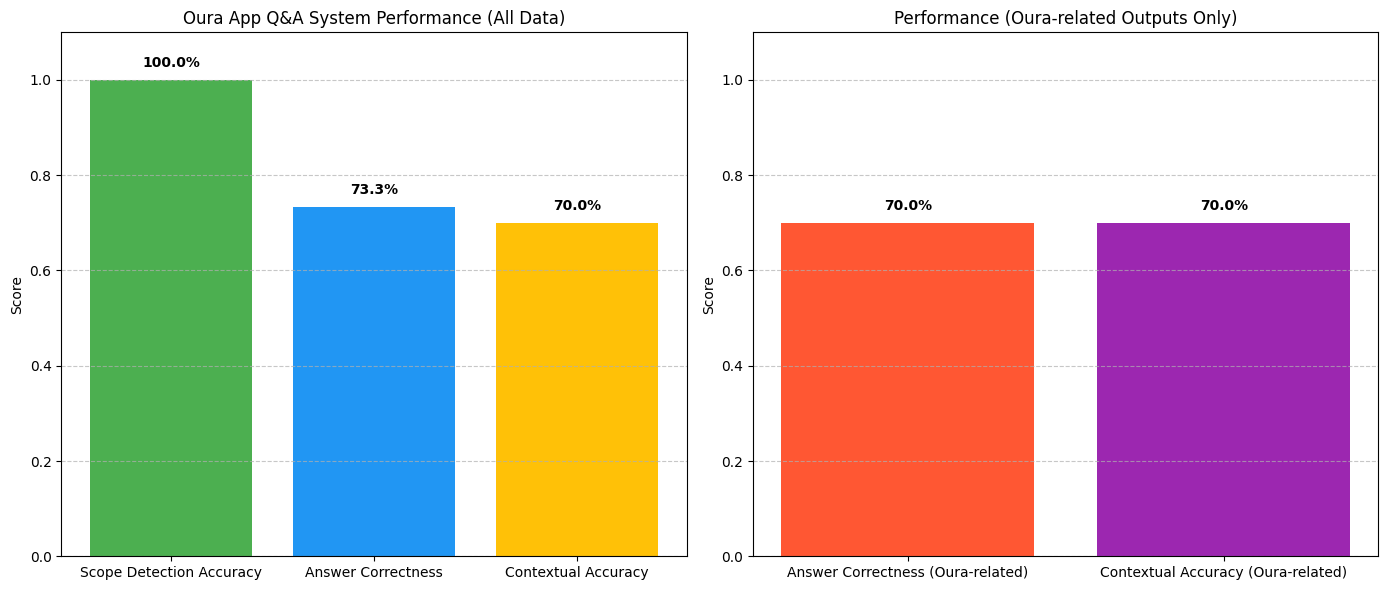

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Print the first few rows for reference
print(df.head())

# Calculate key metrics based on the provided DataFrame
scope_accuracy = (df['outputs.is_oura_related'] == df['reference.true_is_oura_related']).mean()
correctness = df['feedback.Contextual Accuracy'].mean()
oura_related_df = df[df['reference.true_is_oura_related'] == True]
contextual_accuracy = oura_related_df['feedback.Contextual Accuracy'].mean()

# Filter only rows where outputs.is_oura_related == True
oura_related_outputs_df = df[df['outputs.is_oura_related'] == True]

# Calculate Answer Correctness and Contextual Accuracy for filtered rows
answer_correctness_filtered = oura_related_outputs_df['feedback.Contextual Accuracy'].mean()
contextual_accuracy_filtered = oura_related_outputs_df['feedback.Contextual Accuracy'].mean()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot full dataset metrics
metrics = ['Scope Detection Accuracy', 'Answer Correctness', 'Contextual Accuracy']
values = [scope_accuracy, correctness, contextual_accuracy]
bars = axes[0].bar(metrics, values, color=['#4CAF50', '#2196F3', '#FFC107'])

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel('Score')
axes[0].set_title('Oura App Q&A System Performance (All Data)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Oura-related-only metrics
metrics_filtered = ['Answer Correctness (Oura-related)', 'Contextual Accuracy (Oura-related)']
values_filtered = [answer_correctness_filtered, contextual_accuracy_filtered]
bars_filtered = axes[1].bar(metrics_filtered, values_filtered, color=['#FF5733', '#9C27B0'])

for bar in bars_filtered:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

axes[1].set_ylim(0, 1.1)
axes[1].set_ylabel('Score')
axes[1].set_title('Performance (Oura-related Outputs Only)')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('performance_metrics_comparison.png')
plt.show()


# **Conclusions**

This notebook demonstrates a framework for building a specialized Oura assistant for Oura app questions. The implementation combines web scraping, vector embeddings, query classification, and retrieval-augmented generation to create a focused question-answering system.

While our current performance metrics show promise (100% scope detection accuracy, 73.3% answer correctness), several opportunities exist for enhancement:

1) Expanding the knowledge base with more comprehensive Oura documentation
2) Optimizing chunking strategies, number of retrieved documents and embedding models
3) Refining prompts for both classification and answer generation
4) Increasing evaluation dataset size and diversity

These improvements would likely boost the system's accuracy and utility.

This Oura assistant is also hosted on Gradio by clicking [HERE](https://huggingface.co/spaces/tylervu-main/oura-assistant).